In [2]:
# 드라이브 마운트 하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
shared_dir = '/content/drive/MyDrive/dataset/'

# 데이터 준비

In [4]:
# 필요한 라이브러리 불러오기

import os
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


In [5]:
# neo-antigen 데이터 불러오기
# antigen: epitope sequence
# full_seq: HLA full sequence
# label: 정답 값 (epitope와 HLA의 affinity)

neo = pd.read_csv(shared_dir + 'NeoAntigen_dataset_for_training.csv')

In [6]:
neo

,antigen,allele_name,full_seq,pseudo_seq,label
0,EVMPVSMAK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
1,ATFSVPMEK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
2,RVFNNYMPY,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
3,ATVVIGTSK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
4,SSNVANYQK,HLA-A*11:01,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,1.0
...,...,...,...,...,...
62643,SYIDRLAPR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0
62644,VVAAVRWRR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0
62645,YVFPKPFNR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0
62646,YVQRFHYSR,HLA-A*33:03,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,1.0


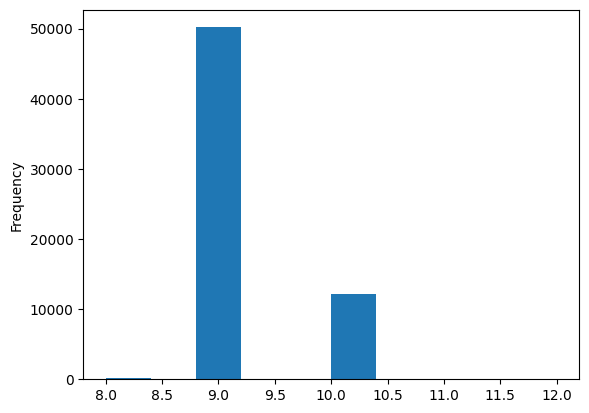

In [7]:
# epitops sequence 길이 분포 살펴보기

neo['antigen'].apply(lambda x: len(x)).plot.hist()
max_seq_epitope = neo['antigen'].apply(lambda x: len(x)).max() # 최대 epitope 길이를 max sequence로 활용하기

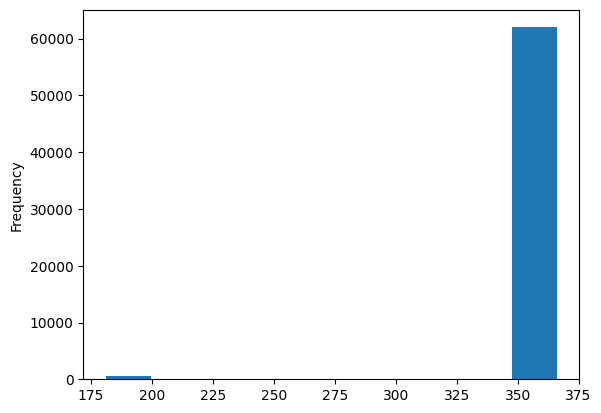

In [8]:
# HLA sequenc 길이 분포 살펴보기

neo['full_seq'].apply(lambda x: len(x)).plot.hist()
max_seq_hla = neo['full_seq'].apply(lambda x: len(x)).max() # 최대 HLA 길이를 max sequence로 활용

# 데이터 전처리 (pre-processing)

In [10]:
!pip install subword_nmt

In [11]:
# Byte Pair Encoding을 위한 라이브러리
from subword_nmt.apply_bpe import BPE

**Epitope processing**
---
이전 강의와 같은 방식으로 epitope one-hot encoding 수행


In [12]:
amino_char = ['?', 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'O',
       'N', 'Q', 'P', 'S', 'R', 'U', 'T', 'W', 'V', 'Y', 'X', 'Z']

# protein, drug 원핫(one-hot) 인코더
enc_protein = OneHotEncoder().fit(np.array(amino_char).reshape(-1, 1))

In [13]:
def trans_protein(x, max_seq_protein):
    """Protein sequence 데이터 전처리하기

    같은 크기(max_seq_protein)의 리스트로 만들기
    사전 정의된 character에 해당 되지 않는 값은 ?로 변환

    Args:
        x, string: 하나의 sequence 데이터

    Return:
        전처리된 SMILES 데이터 리스트
    """
    temp = list(x.upper()) # 대문자로 바꾸기
    temp = [i if i in amino_char else '?' for i in temp] #

    if len(temp) < max_seq_protein:
        # max_seq_protein 보다 작으면 뒷부분을 ?로 채워서 MAX_SEQ_DRUG 길이의 리스트로 만들기
        temp = temp + ['?'] * (max_seq_protein - len(temp))
    else:
        # max_seq_protein 보다 크면 앞에서부터 MAX_SEQ_DRUG 만큼 슬라이싱
        temp = temp [:max_seq_protein]

    return temp

**HLA processing**
---
Byte Pair Encoding을 이용한 HLA encoding

In [14]:
# protein subword data 불러오기

vocab_path = shared_dir + "protein_codes_uniprot_2000.txt"
bpe_codes_protein = open(vocab_path)
pbpe = BPE(bpe_codes_protein, merges=-1, separator='')
sub_csv = pd.read_csv(shared_dir + "subword_units_map_uniprot_2000.csv") # subword vocab

In [15]:
full_seq = pd.Series(neo["full_seq"])[0]
print(full_seq)
print(pbpe.process_line(full_seq))

MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHAAEQQRAYLEGRCVEWLRRYLENGKETLQRTDPPKTHMTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWELSSQPTIPIVGIIAGLVLLGAVITGAVVAAVMWRRKSSDRKGGSYTQAASSDSAQGSDVSLTACKV
MAV MAP RT LL LLL SG ALAL TQ TW AGS HS MRY FY TS VS RPG RG EP RF I AVG Y VDD TQ FVR F DSD AAS QR ME PR AP WIE QEG PE Y WD QE TR NVK AQ SQ TD RV DLG TL RG YY NQ SE DGS HT IQ IM YG CD VG PDG RFL RG YR QD AY DG KD YI ALNE DL RS W TAA DM AAQ IT KR K WE AA H AAE QQ R AYL EG RC VE WL RR YLE NG KETL QR TD PP KT HM TH HP ISD HE ATL RC W ALG FYP AE ITL TW QR DG ED QT QD TEL VE TR PAG DG TF QK WAA VV VP SG EE QR YT CH VQ HE GL PK PLTL RW ELSS QP TIP IVG II AGL VLLG AV ITG AV VAA VM WRR KSS D RK GG SY TQ AASS DS AQG SD VSL TAC K V


[subword-mnt github](https://github.com/rsennrich/subword-nmthttps://)

In [16]:
idx2word_p = sub_csv['index'].values
words2idx_p = dict(zip(idx2word_p, range(0, len(idx2word_p)))) # subword : index

In [17]:

def hla2emb_encoder(x):
    t1 = pbpe.process_line(x).split()  # protein sequence subword로 나누기
    try:
        i1 = np.asarray([words2idx_p[i] for i in t1])  # 단어 집합에 있는 경우 해당 index 가져오기
    except:
        i1 = np.array([0]) # 없는 경우 0으로 채우기

    l = len(i1) # 전체 sequence 길이

    if l < max_seq_hla:
        # max_seq 보다 작으면 나머지 부분 0으로 채우기
        i = np.pad(i1, (0, max_seq_hla - l), 'constant', constant_values = 0) # 0으로 채우기 (zero padding)
        input_mask = ([1] * l) + ([0] * (max_seq_hla - l)) # zero padding 한 부분 이 후 transformer에서 masking
    else:
        # max_seq 보다 크면 max_seq 만큼 앞에서부터 slicing
        i = i1[:max_seq_hla]
        input_mask = [1] * max_seq_hla

    return i, np.asarray(input_mask)

In [18]:

t1 = pbpe.process_line(full_seq).split()  # protein sequence subword로 나누기

try:
    i1 = np.asarray([words2idx_p[i] for i in t1])  # 단어 집합에 있는 경우 해당 index 가져오기
except:
    i1 = np.array([0]) # 없는 경우 0으로 채우기

i1

array([ 873, 1560,  159,   25,  194,   45, 1701,  172,  347,  482,  158,
       2934,  204,   94,   64,  806,   78,  249,  153,   22,  326,   12,
        789,  172, 1382,    3,  971,  381,  136,  137,  260,   83, 2360,
        730,   65,   12,  331,  104,  135, 1307,   72,  276,  127,  200,
        352,   35,   78,  250,  288,   88,  589,  297,  144,  293,  108,
        303,   58, 1015,  786,   78,  257,  156,  114,   73,  112,  325,
       3850,   36,  107,   23,  443,  360,  975,   79,  110,   15,  302,
         26,   24,  332,   98,   18,  425,  146,  370,   54,  145,   61,
        800,   81, 3239,  136,  127,  115,  116,  590,  215,  175,  835,
        170,  274,  370,   23,  251, 2778,   43,  686,  347,  136,   73,
        191,  205,  156,  666,   54,  135,  983,   73,  147,  196, 1940,
         42,   90,   45,   34,  136,  272,  496,  120,  170,   29,  280,
       3403,  372, 3357,  163, 1254,  558,  122,  218, 2673,   39,  696,
         39,  299,  155, 2164,  659,   21,  168,   

**전체 데이터 전처리 & 데이터 나누기**

In [19]:
def create_fold(df, fold_seed, frac):
    """Train / Val / Test 나누기

    Args:
        df: 전체 데이터 (Pandas DataFrame)
        fold_seed: random_state for random sampling
        frac: train - val - test fraction (list or tuple) ex) [0.7,0.1,0.2]

    Returns:
        Train / Val / Test dataframe (tuple)
    """
    train_frac, val_frac, test_frac = frac

    # Test 데이터 random sampling
    test = df.sample(frac = test_frac, replace = False, random_state = fold_seed)
    train_val = df[~df.index.isin(test.index)] # Train & Validation 데이터

    # Validation 데이터 random sampling
    val = train_val.sample(frac = val_frac/(1-test_frac), replace = False, random_state = 1)
    train = train_val[~train_val.index.isin(val.index)] # Train 데이터

    return train, val, test

In [20]:
def process_data(df, seed, frac):

    # epitope 데이터 중 중복되지 않는 것만 processing
    AA = pd.Series(df['antigen'].unique()).apply(lambda x: trans_protein(x, max_seq_epitope))
    # raw epitope : processed epitope
    AA_dict = dict(zip(df['antigen'].unique(), AA))
    # 전체 데이터 processing
    df['antigen_processed'] = [AA_dict[i] for i in df['antigen']]

    # HLA seq 데이터 중 중복되지 않는 것만 processing
    AA = pd.Series(neo["full_seq"].unique()).apply(hla2emb_encoder)
    # HLA seq : BPE encoded seq 딕셔너리
    AA_dict = dict(zip(neo["full_seq"].unique(), AA))
    # 전체 데이터 processing
    neo["hla_processed"] = [AA_dict[i] for i in neo["full_seq"]]

    train, val, test = create_fold(df, seed, frac)

    return train, val, test


In [21]:
train, val, test = process_data(neo, 22, [0.7,0.1,0.2])

In [22]:
def protein_2_embed(x):
    return enc_protein.transform(np.array(x).reshape(-1,1)).toarray().T

# Torch DataSet & DataLoader

In [23]:
class data_process_loader(Dataset):
    def __init__(self, df):
        """
        Args:
            df: Paired drug - protein - affinity dataframe
        """
        self.df = df

    def __len__(self):
        """샘플 개수
        """
        return self.df.shape[0]

    def __getitem__(self, index):
        # Epitope
        v_e = self.df.iloc[index]['antigen_processed']
        v_e = protein_2_embed(v_e)

        # HLA seq
        v_h = self.df.iloc[index]['hla_processed']
        # v_h = protein_2_embed(v_h)

        # Binding affinity (label)
        y = self.df.iloc[index]['label']

        return v_e, v_h, y


In [24]:
train_dataset = data_process_loader(train)
val_dataset = data_process_loader(val)
test_dataset = data_process_loader(test)

In [25]:
# Dataset 확인 해보기

for (v_e, v_h, y) in train_dataset:
    print(v_e.shape)
    print(v_h[0].shape)
    print(v_h[1].shape)
    print(y)
    break

(26, 12)
(366,)
(366,)
1.0


In [26]:
# DataLoader 파라미터

params = {'batch_size': 256,
            'shuffle': True,
            'num_workers': 1,
            'drop_last': False}

In [27]:
# Mini-batch 학습을 위한 DataLoader

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(val_dataset, **params)
test_generator = DataLoader(test_dataset, **params)


In [28]:
# Dataloader 확인해보기

for (v_e, v_h, y) in training_generator:
    print(v_e.shape)
    print(v_h[0].shape)
    print(v_h[1].shape)
    print(y)
    break

torch.Size([256, 26, 12])
torch.Size([256, 366])
torch.Size([256, 366])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 

In [29]:

for (v_e, v_h, y) in valid_generator:
    print(v_e.shape)
    print(v_h[0].shape)
    print(v_h[1].shape)
    print(y)
    break

torch.Size([256, 26, 12])
torch.Size([256, 366])
torch.Size([256, 366])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 

In [30]:
for (v_e, v_h, y) in test_generator:
    print(v_e.shape)
    print(v_h[0].shape)
    print(v_h[1].shape)
    print(y)
    break

torch.Size([256, 26, 12])
torch.Size([256, 366])
torch.Size([256, 366])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 

# 모델 학습 (Training)

### 모델 설정 및 선언


In [31]:
# 모델 설정 값

config = {
    # epitope 설정 (CNN)
    "cnn_epitope_filters" : [32,64,96],
    "cnn_epitope_kernels" : [3,3,3],
    'hidden_dim_epitope': 128,
    'max_seq_epitope' : max_seq_epitope,

    # HLA (tranformer)
    'input_dim_hla': 4114, # subword vocab 크기
    'hidden_dim_hla': 64, # transformer embedding 크기
    'transformer_attention_probs_dropout': 0.1, # self-attention 연산 과정에서 적용되는 dropout
    'transformer_dropout_rate': 0.1, # word embedding - layer norm 이 후 적용되는 dropout
    'transformer_emb_size': 64, # word embedding 후 크기
    'transformer_hidden_dropout_rate': 0.1, # MLP에서 적용되는 dropout
    'transformer_intermediate_size': 256, # self-attention 이 후 MLP
    'transformer_n_layer': 2, # transformer 인코더 개수
    'transformer_num_attention_heads': 4, # self attention 시 head 개수

    # classifier
    'cls_hidden_dims': [1024, 1024, 512],
    }

### CNN embedding

In [32]:
class CNN(nn.Sequential):
    def __init__(self, encoding, **config):
        super(CNN, self).__init__()

        in_ch = [26] + config[f'cnn_{encoding}_filters']
        kernels = config[f'cnn_{encoding}_kernels']
        layer_size = len(config[f'cnn_{encoding}_filters'])

        self.conv = nn.ModuleList([nn.Conv1d(in_channels = in_ch[i],
                                    out_channels = in_ch[i+1],
                                    kernel_size = kernels[i]) for i in range(layer_size)])

        self.conv = self.conv.double()

        max_seq = config[f'max_seq_{encoding}']
        n_size_d = self._get_conv_output((26, max_seq))
        self.fc1 = nn.Linear(n_size_d, config[f'hidden_dim_{encoding}'])

    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input.double())
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x):
        for l in self.conv:
            x = F.relu(l(x))
        x = F.adaptive_max_pool1d(x, output_size=1)
        return x

    def forward(self, v):
        v = self._forward_features(v.double())
        v = v.view(v.size(0), -1)
        v = self.fc1(v.float())
        return v

### Transformer embedding

In [33]:
import copy
import math
import collections

**Word embedding과 postional encodding**


---


![](https://drive.google.com/uc?export=view&id=14UwLW9eQf5zDPznytq3La1ylv75xFq1O)


In [34]:
class LayerNorm(nn.Module):
    """word embedding 이 후 적용되는 layer normalization
    """
    def __init__(self, hidden_size, variance_epsilon=1e-12):

        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class Embeddings(nn.Module):
    """Construct the embeddings from protein/target, position embeddings.
    """
    def __init__(self, vocab_size, hidden_size, max_position_size, dropout_rate):
        """
        Args:
            vocab_size: int. subword vocab 크기
            hidden_size: int. word embedding 이 후 사이즈
            max_postion_size: int. 한 sequence 내에서 가질 수 있는 postion 가짓수 (== sequence size)
            dropout_rate: float. embedding 이 후 dropout prob. [0, 1]
        """
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_size, hidden_size)

        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids):
        seq_length = input_ids.size(1) # input squence 크기
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # [0, ... ,input sequence size]
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids) # (sequence_size, ) -> (batch size, sequence_size)

        words_embeddings = self.word_embeddings(input_ids) # (batch size, sequence_size) -> (batch size, sequence_size, hidden_size)
        position_embeddings = self.position_embeddings(position_ids) # (batch size, sequence_size) -> (batch size, sequence_size, hidden_size)

        # input embedding 에 postional encodding 더해주기
        embeddings = words_embeddings + position_embeddings
        # Layer normalizaton
        embeddings = self.LayerNorm(embeddings)
        # dropout 적용
        embeddings = self.dropout(embeddings)
        return embeddings


**Self-attention block**

---

![](https://drive.google.com/uc?export=view&id=1qP1nH5NKTtfEHrp9xhacYcDujCCZo2C6)



In [35]:
class SelfAttention(nn.Module):
    """Query, Key, Value matrix를 이용해 multi-head self-attention 수행하기
    """
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        """
        Args:
            hidden_size: int; word embedding 사이즈
            num_attention_heads: int; self-attention(SA) 시 head 개수
            attention_probs_dropout_prob: float; SA 이 후 dropout 확률
        """

        super(SelfAttention, self).__init__()
        if hidden_size % num_attention_heads != 0:
            # head의 개수가 hidden_size의 약수가 아니면 오류 출력
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))

        self.num_attention_heads = num_attention_heads # MSA에서 head 개수
        self.attention_head_size = int(hidden_size / num_attention_heads) # 각 헤드에서 query, key, value 차원 크기
        self.all_head_size = hidden_size # attention_head_size * num_attention_heads

        # Query, Key, Value parameter 생성 (hidden_size x (attention_head_size * num_attention_heads))
        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        """self attention 수행을 위해 permutation 진행
        """
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # (batch_size x vocab_size x num_attention_heads x attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3) # (batch_size x num_attention_heads x vocab_size  x attention_head_size)

    def forward(self, hidden_states, attention_mask):
        # 모든 head의 query, key, value matrix 한번에 생성하기
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # 헤드 별로 qurey, key, value matrix 나누기
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # query, key matrix 곱으로 attention scores 구하기
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        # attention_head_size로 scaling
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # attention mask 값 더하기 (masking 할 부분에 매우 작은 음수 값 더해주기)
        attention_scores = attention_scores + attention_mask

        # softmax를 이용하여 attention score [0,1]의 값으로 만들기
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # self attention 이 후 dropout
        attention_probs = self.dropout(attention_probs)

        # [0,1]의 attention score로 각 토큰 value의 가중합 구하기
        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() # (batch_size x vocab_size x num_attention_heads x attention_head_size)
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) # (batch_size x vocab_size x all_head_size)
        context_layer = context_layer.view(*new_context_layer_shape)

        return context_layer


class SelfOutput(nn.Module):
    """Self-attention 이 후 multi layer perceptron
    """
    def __init__(self, hidden_size, hidden_dropout_prob):
        super(SelfOutput, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class Attention(nn.Module):
    """Self attention + MLP
    """
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.self_attention = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.self_output = SelfOutput(hidden_size, hidden_dropout_prob)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self_attention(input_tensor, attention_mask)
        attention_output = self.self_output(self_output, input_tensor)
        return attention_output


**MLP embedding**

---



In [36]:
class Intermediate(nn.Module):
    """SA 이 후 Non-linear layers
    """
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states

class Output(nn.Module):
    """ 최종 linear embedding
    """
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

**Self attention block과 MLP를 합쳐 encoder 만들기**

---



In [37]:
# SA + MLP
class Encoder(nn.Module):
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Encoder, self).__init__()
        self.attention = Attention(hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob)
        self.intermediate = Intermediate(hidden_size, intermediate_size)
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

# n_layer 만큼 encoder 쌓기
class Encoder_MultipleLayers(nn.Module):
    def __init__(self, n_layer, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Encoder_MultipleLayers, self).__init__()
        layer = Encoder(hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layer)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
            #if output_all_encoded_layers:
            #    all_encoder_layers.append(hidden_states)
        #if not output_all_encoded_layers:
        #    all_encoder_layers.append(hidden_states)
        return hidden_states


**Transformer embedder**

In [38]:
class transformer(nn.Sequential):
    def __init__(self, encoding, **config):
        super(transformer, self).__init__()

        if encoding == 'hla':
            self.emb = Embeddings(config['input_dim_hla'], config['transformer_emb_size'], 366, config['transformer_dropout_rate'])
            self.encoder = Encoder_MultipleLayers(config['transformer_n_layer'],
                                                config['transformer_emb_size'],
                                                config['transformer_intermediate_size'],
                                                config['transformer_num_attention_heads'],
                                                config['transformer_attention_probs_dropout'],
                                                config['transformer_hidden_dropout_rate'])

    ### parameter v (tuple of length 2) is from utils.drug2emb_encoder
    def forward(self, v):
        e = v[0].long().to(device) # subword encoding 된 input
        e_mask = v[1].long().to(device) # masking table (0 또는 1 값만 가짐)
        ex_e_mask = e_mask.unsqueeze(1).unsqueeze(2)
        ex_e_mask = (1.0 - ex_e_mask) * -10000.0 # (if 0 -> 매우 작은 음수 값, else -> 0 )

        emb = self.emb(e) # word embedding - postional encodding - layer normalization 진행
        encoded_layers = self.encoder(emb.float(), ex_e_mask.float()) # self-attention block + MLP embedding layer
        return encoded_layers[:,0]

### Embedding 된 vector를 이용하여 최종 예측에 활용되는 classifier

In [39]:
class Classifier(nn.Sequential):
	"""임베딩 된 epitope와 HLA 이용하여 classificaion
	"""
	def __init__(self, model_epitope, model_hla, **config):
		"""
		Args:
			model_epitope: epitope emedding 모델
			model_hla: hla emedding 모델
			config: 모델 설정 값
		"""
		super(Classifier, self).__init__()

		self.input_dim_epitope = config['hidden_dim_epitope'] # epitope feature 사이즈
		self.input_dim_hla = config['hidden_dim_hla'] # hla feature 사이즈

		self.model_epitope = model_epitope # epitope 임베딩 모델
		self.model_hla = model_hla # hla 임베딩 모델

		self.dropout = nn.Dropout(0.1) # dropout 적용

		self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
		layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
		dims = [self.input_dim_epitope + self.input_dim_hla] + self.hidden_dims + [1] # ["합쳐진 feature 차원 (epitope + hla), hidden1, hidden2, hidden3, 1 (output layer)]

		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifer layers

	def forward(self, v_D, v_P):
		# epitope/hla 임베딩
		v_E = self.model_epitope(v_D)
		v_H = self.model_hla(v_P)

		# epitope - hla feature 합치기
		v_f = torch.cat((v_E, v_H), 1)

		for i, l in enumerate(self.predictor):
			if i == (len(self.predictor)-1):
				# If last layer,
				v_f = l(v_f)
			else:
				# If Not last layer, dropout과 ReLU 적용
				v_f = F.relu(self.dropout(l(v_f)))

		return v_f


### 학습 진행

In [40]:
# 디바이스 설정

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 cuda:0 입니다.


In [41]:
# model for drug
model_epitope = CNN('epitope', **config)

# model for protein
model_hla = transformer('hla', **config)

# classifier
model = Classifier(model_epitope, model_hla, **config)

model = model.to(device)

In [42]:
from prettytable import PrettyTable
from time import time

from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score, log_loss

In [43]:
# 하이퍼 파라미터(hyper parameter)

learning_rate = 0.001
weight_decay  = 0.00001
train_epoch   = 20

In [44]:
# 옵티마이저 선언
opt = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay) # Adam optimizer

# 손실 함수 선언
loss_fct = torch.nn.BCELoss()

# 시그모이드(sigmoid) 함수
sigmoid = torch.nn.Sigmoid()

In [45]:
def get_metrics(y_label, y_pred):
    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

    # metrics
    auc = roc_auc_score(y_label, y_pred) # AUC
    auprc = average_precision_score(y_label, y_pred) # Average Precision
    f1 = f1_score(y_label, outputs) # F1 score
    lloss = log_loss(y_label, outputs) # cross-entropy loss

    return auc, auprc, f1, lloss

In [47]:
loss_history = []

max_auc = 0 # 최고 AUC 저장
model_max = copy.deepcopy(model) # 최고 AUC 저장

valid_metric_record = [] # 각 metrics 저장
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["AUROC", "AUPRC", "F1"])

table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x  # float 자료 형 str로 만들기 (소숫점 4자리까지)

print('--- Go for Training ---')
t_start = time()


for epoch in range(train_epoch):
    # Training
    model.train()

    for i, (v_e, v_h, label) in enumerate(training_generator):
        v_h = tuple(map(lambda x: x.float().to(device), v_h))
        v_e = v_e.float().to(device)

        # 순전파 (forward-pass)
        score = model(v_e, v_h)
        label = Variable(torch.from_numpy(np.array(label)).float()).to(device) # label numpy -> torch tensor

        # 모델 아웃풋 score -> probability
        n = torch.squeeze(sigmoid(score), 1)

        # 손실 값(loss) 계산
        loss = loss_fct(n, label)
        loss_history.append(loss.item()) # loss 기록

        opt.zero_grad() # gradient 초기화
        loss.backward() # back propagation
        opt.step() # parameter 업데이트

    # Validation
    model.eval()
    with torch.set_grad_enabled(False):
        y_pred = []
        y_label = []

        for i, (v_e, v_h, label) in enumerate(valid_generator):
            v_h = tuple(map(lambda x: x.float().to(device), v_h))
            v_e = v_e.float().to(device)

            # 순전파 (forward-pass)
            score = model(v_e, v_h)

            logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy() # 예측 확률
            label_ids = label.to('cpu').numpy() # 참 값

            y_label = y_label + label_ids.flatten().tolist()
            y_pred = y_pred + logits.flatten().tolist()

    # 예측 값
    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

    # model evaluation
    auc, auprc, f1, lloss = get_metrics(y_label, y_pred)

    lst = ["epoch " + str(epoch)] + list(map(float2str,[auc, auprc, f1]))
    valid_metric_record.append(lst)

    if auc > max_auc:
        # 이전 epoch 보다 AUC 좋아지면 model_max, max_auc 갱신
        model_max = copy.deepcopy(model)
        max_auc = auc

    print('Validation at Epoch '+ str(epoch + 1) + ', AUROC: ' + str(auc)[:7] + \
            ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:7] + ' , Cross-entropy Loss: ' + \
            str(lloss)[:7])


    table.add_row(lst)



--- Go for Training ---
Validation at Epoch 1, AUROC: 0.79152 , AUPRC: 0.60509 , F1: 0.45194 , Cross-entropy Loss: 7.38132
Validation at Epoch 2, AUROC: 0.85756 , AUPRC: 0.70666 , F1: 0.58416 , Cross-entropy Loss: 6.22493
Validation at Epoch 3, AUROC: 0.87722 , AUPRC: 0.72890 , F1: 0.56787 , Cross-entropy Loss: 6.19041
Validation at Epoch 4, AUROC: 0.91616 , AUPRC: 0.82311 , F1: 0.70626 , Cross-entropy Loss: 4.69459
Validation at Epoch 5, AUROC: 0.92002 , AUPRC: 0.82156 , F1: 0.71477 , Cross-entropy Loss: 4.75212
Validation at Epoch 6, AUROC: 0.93392 , AUPRC: 0.85151 , F1: 0.75232 , Cross-entropy Loss: 4.29186
Validation at Epoch 7, AUROC: 0.93564 , AUPRC: 0.85316 , F1: 0.75591 , Cross-entropy Loss: 4.21707
Validation at Epoch 8, AUROC: 0.93834 , AUPRC: 0.86116 , F1: 0.77363 , Cross-entropy Loss: 4.09050
Validation at Epoch 9, AUROC: 0.94076 , AUPRC: 0.86415 , F1: 0.77489 , Cross-entropy Loss: 4.04448
Validation at Epoch 10, AUROC: 0.94445 , AUPRC: 0.87169 , F1: 0.77107 , Cross-entropy

# 모델 테스트 (Test)

In [48]:
model = model_max
model.eval()

y_pred = []
y_label = []
y_outputs = []

for i, (v_e, v_h, label) in enumerate(test_generator):
    v_h = tuple(map(lambda x: x.float().to(device), v_h))
    v_e = v_e.float().to(device)

    # 순전파(forward-pass)
    score = model(v_e, v_h)
    logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy()

    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()
    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

    y_outputs.append(outputs)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [49]:
# model evaluation
auc, auprc, f1, lloss = get_metrics(y_label, y_pred)

print('Test result - ' + ', AUROC: ' + str(auc)[:7] + ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:7] + ' , Cross-entropy Loss: ' + str(loss)[:7])

Test result - , AUROC: 0.95325 , AUPRC: 0.88396 , F1: 0.80523 , Cross-entropy Loss: tensor(


In [50]:
def roc_curve(y_pred, y_label, figure_file, method_name):
	'''ROC 커브 그리기

	Args:
		y_pred: 예측 확률 값이 담긴 리스트 [0,1]
		y_label: 참 값 (0/1)
	'''

	import matplotlib.pyplot as plt
	from sklearn.metrics import roc_curve, auc
	from sklearn.metrics import roc_auc_score

	y_label = np.array(y_label)
	y_pred = np.array(y_pred)

	fpr = dict()
	tpr = dict()
	roc_auc = dict()

	fpr[0], tpr[0], _ = roc_curve(y_label, y_pred) # FPR / TPR 구하기
	roc_auc[0] = auc(fpr[0], tpr[0]) # AUC 구하기

	# ROC 커브 그리기
	lw = 2
	plt.plot(fpr[0], tpr[0],
         lw=lw, label= method_name + ' (area = %0.2f)' % roc_auc[0])
	plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	fontsize = 14
	plt.xlabel('False Positive Rate', fontsize = fontsize)
	plt.ylabel('True Positive Rate', fontsize = fontsize)
	plt.title('Receiver Operating Characteristic Curve')
	plt.legend(loc="lower right")
	plt.savefig(figure_file)


def prauc_curve(y_pred, y_label, figure_file, method_name):
	'''Precision-Recall 커브 그리기

	Args:
		y_pred: 예측 확률 값이 담긴 리스트 [0,1]
		y_label: 참 값 (0/1)
	'''
	import matplotlib.pyplot as plt
	from sklearn.metrics import precision_recall_curve, average_precision_score
	from sklearn.metrics import f1_score
	from sklearn.metrics import auc

	lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred) # precision, recall 구하기

	# 커브 그리기
	plt.plot(lr_recall, lr_precision, lw = 2, label= method_name + ' (area = %0.2f)' % average_precision_score(y_label, y_pred))
	fontsize = 14
	plt.xlabel('Recall', fontsize = fontsize)
	plt.ylabel('Precision', fontsize = fontsize)
	plt.title('Precision Recall Curve')
	plt.legend()
	plt.savefig(figure_file)


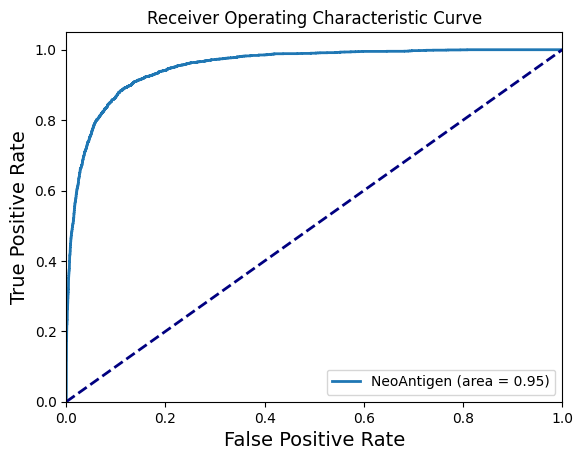

In [51]:
roc_curve(y_pred, y_label, "NeoAntigen.png", "NeoAntigen")

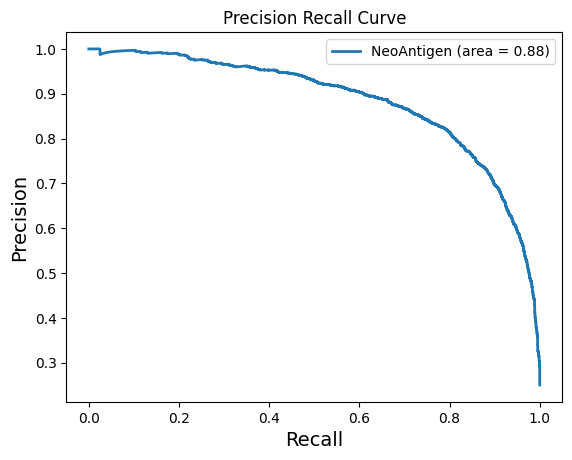

In [52]:
prauc_curve(y_pred, y_label, "NeoAntigen.png", "NeoAntigen")